# Clustering by user-problem matrix
Clustering a binary matrix of users and problems they solved.

This was done mostly for exploration, since this regression is not easily scalable for production (would need to be re-trained for new problems each time)

In [1]:
from scipy.sparse import csr_matrix
import numpy as np
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [231]:
import psycopg2
con = psycopg2.connect(database='codeforces', user='Joy')
cur = con.cursor()
q = """
SELECT handle, contestid, problemid
FROM submissions
WHERE
    participanttype!='CONTESTANT'
group by handle, contestid, problemid
"""
cur.execute(q)
keys_practice = cur.fetchall()

[('-----', '106', 'A'),
 ('-----', '110', 'A'),
 ('-----', '110', 'B'),
 ('-----', '112', 'A'),
 ('-----', '112', 'B'),
 ('-----', '114', 'A'),
 ('-----', '116', 'C'),
 ('-----', '117', 'C'),
 ('-----', '118', 'A'),
 ('-----', '120', 'B'),
 ('-----', '124', 'A'),
 ('-----', '131', 'C'),
 ('-----', '230', 'D'),
 ('-----', '50', 'B'),
 ('-----', '58', 'A'),
 ('----ensist----', '1', 'A'),
 ('----ensist----', '158', 'A'),
 ('----ensist----', '208', 'A'),
 ('----ensist----', '216', 'A'),
 ('----ensist----', '217', 'A'),
 ('----ensist----', '217', 'B'),
 ('----ensist----', '218', 'A'),
 ('----ensist----', '218', 'B'),
 ('----ensist----', '218', 'C'),
 ('----ensist----', '218', 'D'),
 ('----ensist----', '219', 'A'),
 ('----ensist----', '219', 'B'),
 ('----ensist----', '219', 'C'),
 ('----ensist----', '220', 'A'),
 ('----ensist----', '221', 'C'),
 ('----ensist----', '263', 'A'),
 ('----ensist----', '263', 'B'),
 ('----ensist----', '266', 'A'),
 ('----ensist----', '266', 'B'),
 ('----ensist----

In [2]:
with open('handle_cid_pid_keys.txt') as f:
    hcp = [c.strip().split(',') for c in f.readlines()]

In [3]:
handles = [x[0] for x in hcp]

problems = [x[1] + "_" + x[2] for x in hcp]

## Hash handles and problems to rows and columns

In [4]:
hh = {}
hp = {}

row = 0
for h in handles:
    if h not in hh:
        hh[h] = row
        row += 1
col = 0
for p in problems:
    if p not in hp:
        hp[p] = col
        col += 1

In [5]:
row_idx = [hh[h] for h in handles]
col_idx = [hp[p] for p in problems]

In [6]:
# sanity check
print len(row_idx)
print len(col_idx)

7526161
7526161


## Create sparse matrix in CSR format

In [75]:
# csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
ones = np.ones(len(row_idx))
csr = csr_matrix((ones, (row_idx, col_idx)))

In [76]:
csr.shape

(56696, 9973)

In [8]:
svd = TruncatedSVD(n_components=5, n_iter=10, random_state=42)

In [9]:
svd.fit(csr) 

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=10,
       random_state=42, tol=0.0)

In [10]:
print svd.explained_variance_ratio_ 
print svd.explained_variance_ratio_.sum()

[ 0.10925832  0.04649858  0.03612382  0.02594963  0.01584698]
0.233677316953


In [11]:
csr_svd = svd.transform(csr)

In [12]:
csr_svd.shape

(56696, 5)

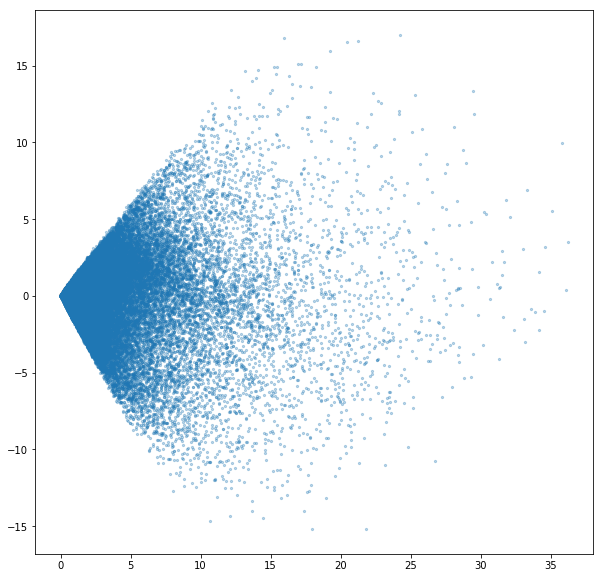

In [13]:
plt.scatter(csr_svd[:, 0], csr_svd[:, 1], s=5, alpha=.3)

###  TSNE dies with large data, sub sample

In [35]:
idx = np.random.choice(len(csr_svd), size=10000)
csr_svd_small = csr_svd[idx]

In [30]:
tsne = TSNE()

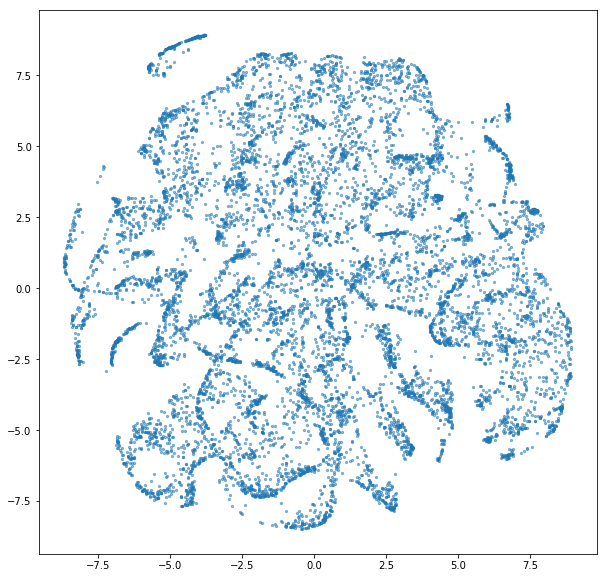

In [36]:
transformed = tsne.fit_transform(csr_svd_small)

plt.scatter(transformed[:, 0], transformed[:,1], s=5, alpha=.5)

# Train/val/test

In [107]:
# reconstruct y column
columns = ['' for i in range(max(hp.values())+1)]
for p in hp:
    columns[ hp[p] ] = p

# reconstruct row labels
rows = ['' for i in range(max(hh.values())+1)]
for h in hh:
    rows[ hh[h] ] = h

In [81]:
# create the ratings vector
ratings = np.zeros(max(hh.values())+1)
for k, v in df_rating.groupby('handle'):
    h = v.handle.values[0]
    if h in hh:
        ratings[ hh[h] ] = v.iloc[-1]['newrating']

In [119]:
with open('set_train.txt') as f:
    settrain = set([t.strip() for t in f.readlines()])
with open('set_test.txt') as f:
    settest = set([t.strip() for t in f.readlines()])
with open('set_val.txt') as f:
    setval = set([t.strip() for t in f.readlines()])

In [122]:
ixtrain = [i for i in range(len(rows)) if rows[i] in settrain]
ixtest = [i for i in range(len(rows)) if rows[i] in settest]
ixval = [i for i in range(len(rows)) if rows[i] in setval]

In [128]:
ytrain = ratings[ixtrain]
print len(ixtrain), ytrain.shape
ytest = ratings[ixtest]
print len(ixtest), ytest.shape
yval = ratings[ixval]
print len(ixval), yval.shape

25137 (25137,)
10629 (10629,)
8181 (8181,)


# Random forest regressor

In [47]:
import pandas as pd
df_rating = pd.read_csv('user_ratings_smoothed.csv')

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rf = RandomForestRegressor()

In [84]:
ntest = 1000
csr_small = csr[0:ntest]
y_small = ratings[0:ntest]

In [129]:
model = rf.fit(csr[ixtrain], ytrain)

In [131]:
print rf.score(csr[ixtrain], ytrain)
print rf.score(csr[ixtest], ytest)
print rf.score(csr[ixval], yval)

0.930647182408
0.707332806907
0.800376415074


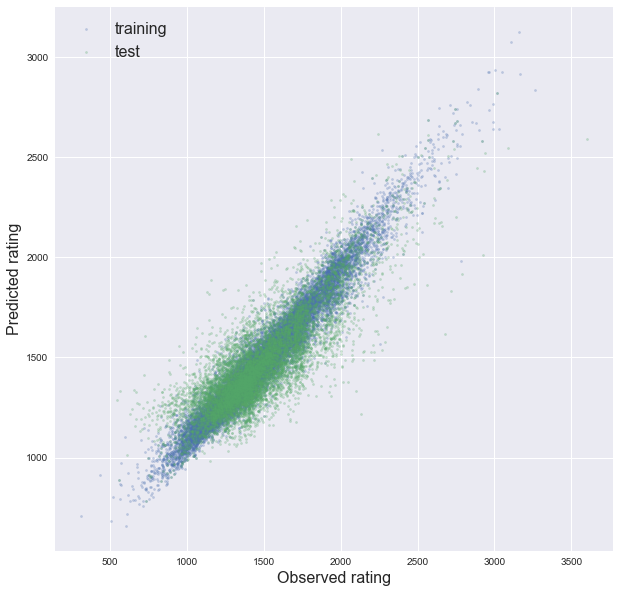

In [229]:
plt.rcParams['figure.figsize'] = (10, 10)
ypred = rf.predict(csr[ixtrain])
plt.scatter(ytrain, ypred, alpha=.3, s=5)
ypred = rf.predict(csr[ixtest])
plt.scatter(ytest, ypred, alpha=.3, s=5)
plt.xlabel('Observed rating', fontsize=16)
plt.ylabel('Predicted rating', fontsize=16)
plt.legend(['training', 'test'], fontsize=16)

In [133]:
imp = pd.Series(rf.feature_importances_)
imp.index = columns

In [135]:
impsorted = imp.sort_values(ascending=False)

In [145]:
problem_rating = pd.read_csv("problem_ratings.csv")
problem_rating['contestid'] = problem_rating.contestid.apply(str)
problem_rating['contestid'] = problem_rating.contestid.apply(lambda x: x + "_")
problem_rating.index = problem_rating.contestid.str.cat(problem_rating.problemid)

In [150]:
imprates = problem_rating.loc[imp.index, 'problemrating']

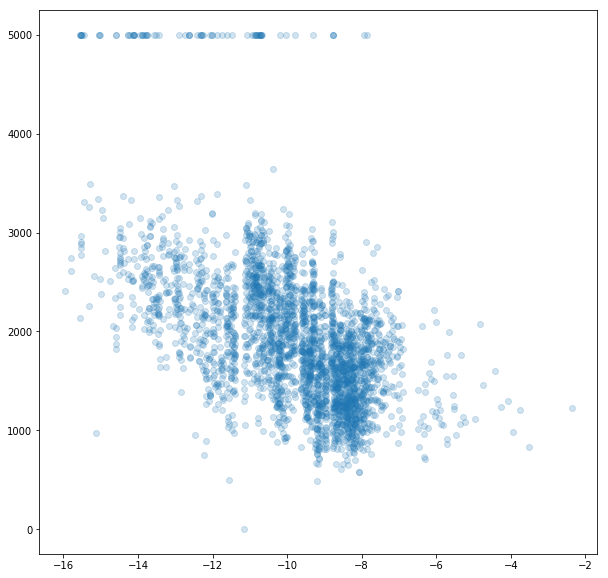

In [165]:
thresh = 0.0000001
plt.scatter(np.log(impsorted[impsorted > thresh]), imprates[impsorted > thresh], alpha=.2)

['4_A' '71_A' '109_B' '128_D' '158_E' '161_B' '161_D' '17_B' '240_B'
 '245_C' '291_C' '301_A' '311_A' '316_B2' '351_A' '351_B' '367_B' '438_A'
 '452_B' '455_B' '458_B' '477_A' '486_A' '486_C' '500_D' '549_D' '576_B'
 '6_A' '696_C' '81_C' '82_B' '85_A' '85_C' '94_B' '767_C' '787_A' '791_C'
 '100519_D']


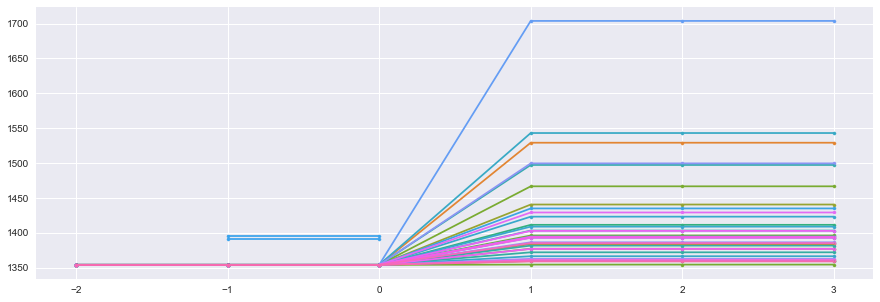

In [220]:
import copy
import seaborn as sns

nvars = 600
ixval = np.argwhere(np.array(rows) == 'yj12')[0][0]
oldrating = rf.predict(csr[ixval])[0]

idx = []
with sns.color_palette("husl", nvars):
    for varidx in range(nvars):
        eps = 1
        x = []
        y = []
        flag = False
        for i in range(3, -3, -1):
            testin = np.array(csr[ixval].toarray())
            testin = testin.reshape(1, -1)
            testin[0][varidx] += eps * i
            
            predicted_newrating = rf.predict(testin)
            
            if predicted_newrating > oldrating or flag:
                flag = True
                x.append(testin[0][varidx])
                y.append(predicted_newrating)
                
        if flag:
            idx.append(varidx)

        plt.rcParams['figure.figsize'] = (15, 5)
        plt.plot(x, y)
        plt.scatter(x, y, s=10)
    #    plt.title(df_train_ok.columns[varidx], fontsize=16)
    
print np.array(columns)[idx]

In [222]:
problem_rating.loc[np.array(columns)[idx]]

,contestid,problemid,problemrating
contestid,,,
4_A,4_,A,1084.0
71_A,71_,A,833.0
109_B,109_,B,1897.0
128_D,128_,D,2001.0
158_E,NaN,NaN,NaN
161_B,161_,B,1716.0
161_D,161_,D,1789.0
17_B,17_,B,1413.0
240_B,240_,B,1683.0
